# Оглавление
1. [Подготовка](#Шаг_1)
2. [Подготовка данных](#Шаг_2)

# 1. Подготовка

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from time import process_time
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Дату переввел в индекс

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.index.is_monotonic

True

порядок соблюдён, атрибут вернул True

In [6]:
data = data.resample('1H').sum()

Выполнено ресемплирование по одному часу

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

После ресемплирования количество соответственно уменьшилось.

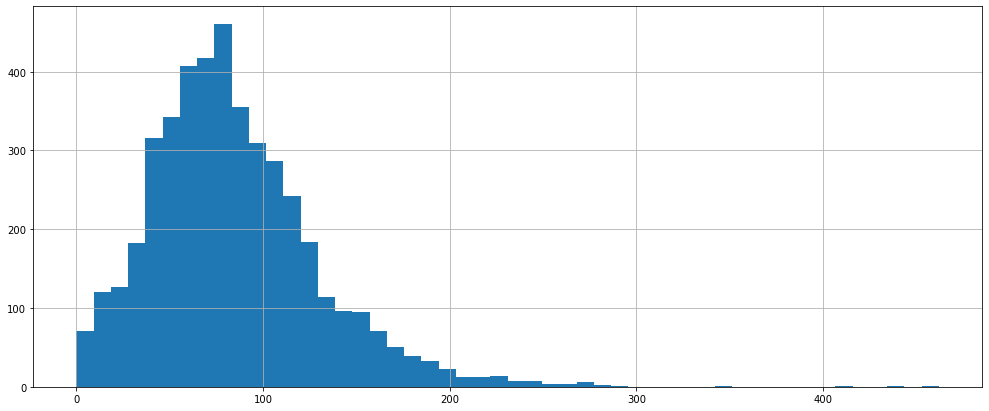

In [10]:
data['num_orders'].hist(bins = 50, figsize = (17, 7))

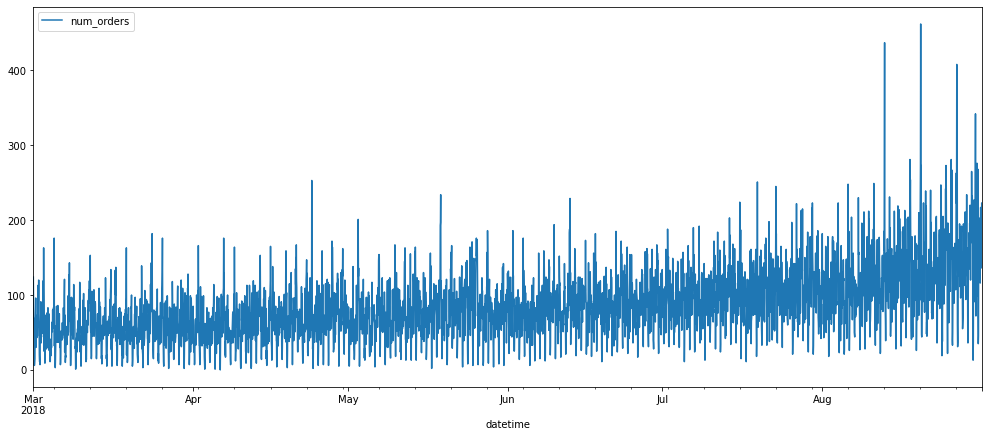

In [11]:
data.plot(figsize = (17, 7))

Распределение нормально. ничего удалять пока не буду

In [12]:
decomposed = seasonal_decompose(data)

In [13]:
data['rolling'] = data['num_orders'].rolling(7).mean()

Text(0.5, 1.0, 'Seasonality')

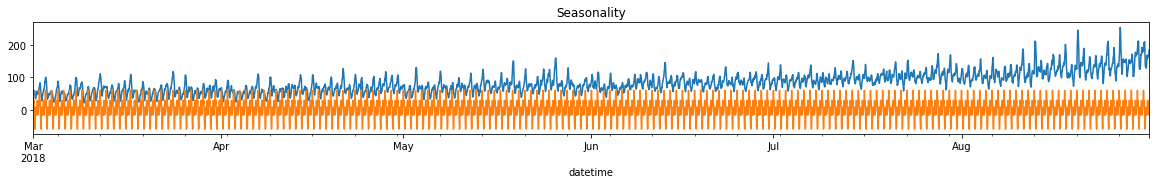

In [14]:
plt.figure(figsize=(20, 7))
plt.subplot(311)
data['rolling'].plot()
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'trend')

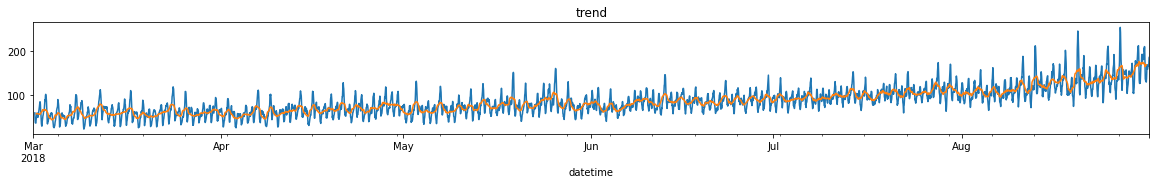

In [15]:
plt.figure(figsize=(20, 7))
plt.subplot(311)
data['rolling'].plot()

decomposed.trend.plot(ax=plt.gca())

plt.title('trend')

In [16]:
data = data.drop(['rolling'], axis = 1)

In [17]:
data['year'] = data.index.year

In [18]:
data['month'] = data.index.month

In [19]:
data['day'] = data.index.day

In [20]:
data['hour'] = data.index.hour

In [21]:
data = data.drop(['year'], axis = 1)

вывел в признаки месяц, день, час. Год убрал, он один

In [22]:
def new_features(data, column, max_lag):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

# 3. Обучение

#### Признаки

In [23]:
new_features(data, 'num_orders', 25)

In [24]:
data['rolling_mean'] = data['num_orders'].shift().rolling(13).mean()

In [25]:
data['rolling_sum'] = data['num_orders'].shift().rolling(23).sum()

In [26]:
data = data.dropna()

In [27]:
train, valid = train_test_split(data, shuffle=False, test_size=0.2)

In [28]:
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

In [29]:
train.shape

(3512, 31)

In [30]:
valid.shape

(439, 31)

In [31]:
test.shape

(440, 31)

##### Признак

In [32]:
feature_train = train.drop(['num_orders'], axis = 1)

In [33]:
feature_valid = valid.drop(['num_orders'], axis = 1)

In [34]:
feature_test = test.drop(['num_orders'], axis = 1)

##### Цель

In [35]:
target_train = train['num_orders']

In [36]:
target_valid = valid['num_orders']

In [37]:
target_test = test['num_orders']

Разбил

Тест тоже сразу разбил

##### array / feature

In [38]:
feature_train = np.array(feature_train)

In [39]:
feature_valid = np.array(feature_valid)

In [40]:
feature_test = np.array(feature_test)

##### array / target

In [41]:
target_train = np.array(target_train)

In [42]:
target_valid = np.array(target_valid)

In [43]:
target_test = np.array(target_test)

#### LinearRegression

In [44]:
start = process_time()

In [45]:
model_LR = LinearRegression().fit(feature_train, target_train)

In [46]:
predict_LR = model_LR.predict(feature_valid)

In [47]:
rmse_LR = mean_squared_error(target_valid, predict_LR) ** 0.5

In [48]:
stop = process_time() 

In [49]:
LR_time = stop-start

#### RandomForestRegressor

In [50]:
for depth in range(1, 100, 10):
    count = []
    model = RandomForestRegressor(max_depth = depth, n_estimators = 10, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(depth, mean_squared_error(target_valid, predict) ** 0.5)

1

49.270603437978416

11

33.04039916792055

21

32.286082226287036

31

32.82918481860636

41

32.724737948593265

51

32.724737948593265

61

32.724737948593265

71

32.724737948593265

81

32.724737948593265

91

32.724737948593265

<font color='brown'> 
между 11 и 31
</font>

In [51]:
for depth in range(11, 31):
    count = []
    model = RandomForestRegressor(max_depth = depth, n_estimators = 10, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(depth, mean_squared_error(target_valid, predict) ** 0.5)

11

33.04039916792055

12

32.92702243393443

13

32.622231476249176

14

32.903770825423194

15

32.52753943558706

16

32.68056666835958

17

32.69779271419337

18

32.85110420630264

19

32.62732615508805

20

33.32025129091784

21

32.286082226287036

22

32.90305398142761

23

32.48016629135379

24

32.482024235403394

25

32.780011507015196

26

32.72753045372791

27

32.66717294244606

28

32.80060622467703

29

32.668046172989

30

32.69030841452711

<font color='brown'> 
итого 21
</font>

In [52]:
for estim in range(1, 100, 10):
    count = []
    model = RandomForestRegressor(max_depth = 21, n_estimators = estim, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(estim, mean_squared_error(target_valid, predict) ** 0.5)

1

45.50709005756649

11

32.178550962172274

21

32.654623759493845

31

32.220645690540806

41

32.50594232482154

51

32.46332814263476

61

32.36528008977874

71

32.337748317289524

81

32.16866013626257

91

32.18584308171486

<font color='brown'> 
между 71 и 91
</font>

In [53]:
for estim in range(71, 91):
    count = []
    model = RandomForestRegressor(max_depth = 21, n_estimators = estim, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(estim, mean_squared_error(target_valid, predict) ** 0.5)

71

32.337748317289524

72

32.27677694359344

73

32.29798049501816

74

32.322027373261356

75

32.240803560432774

76

32.23764752246228

77

32.21799978415741

78

32.21598727118733

79

32.17176952470386

80

32.15586327707065

81

32.16866013626257

82

32.14870173068881

83

32.14715097852958

84

32.09955257132981

85

32.12382746897876

86

32.11923359004139

87

32.16445277629003

88

32.145026853926716

89

32.156653613323776

90

32.148913521427666

<font color='brown'> 
итого 84
</font>

In [54]:
start = process_time()

In [55]:
model_RFR = RandomForestRegressor(max_depth = 21, n_estimators = 84, random_state = 12345).fit(feature_train, target_train)

In [56]:
predict_RFR = model_RFR.predict(feature_valid)

In [57]:
rmse_RFR = mean_squared_error(target_valid, predict_RFR) ** 0.5

In [58]:
stop = process_time() 

In [59]:
RFR_time = stop-start

#### LGBMRegressor

In [60]:
for depth in range(1, 100, 10):
    count = []
    model = lgb.LGBMRegressor(max_depth = depth, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(depth, mean_squared_error(target_valid, predict) ** 0.5)

1

38.66051192366001

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


11

33.001876380882194

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


21

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


31

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


41

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


51

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


61

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


71

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


81

33.001624330411126

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


91

33.001624330411126

<font color='brown'> 
между 1 и 11
</font>

In [61]:
for depth in range(1, 12):
    count = []
    model = lgb.LGBMRegressor(max_depth = depth, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(depth, mean_squared_error(target_valid, predict) ** 0.5)

1

38.66051192366001

2

34.299212957776945

3

33.56069239001521

4

33.25464507066046

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


5

33.33646772049113

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


6

33.07818748363237

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


7

33.459208157639466

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


8

32.79533446928775

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


9

32.98744588322543

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


10

33.12044944476466

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


11

33.001876380882194

<font color='brown'> 
итого 11
</font>

In [62]:
for estim in range(1, 100, 10):
    model = lgb.LGBMRegressor(max_depth = 11, n_estimators = estim, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(estim, mean_squared_error(target_valid, predict) ** 0.5)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


1

55.570654424513904

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


11

39.70834660518438

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


21

34.8236714650532

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


31

33.26712544672211

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


41

32.941041156274814

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


51

32.86920412947765

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


61

32.75563611682163

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


71

32.86474129680531

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


81

33.01460838402404

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


91

33.03061498904202

<font color='brown'> 
между 1 и 11
</font>

In [63]:
for estim in range(51, 71):
    model = lgb.LGBMRegressor(max_depth = 11, n_estimators = estim, random_state = 12345).fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    display(estim, mean_squared_error(target_valid, predict) ** 0.5)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


51

32.86920412947765

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


52

32.86900630221884

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


53

32.82306862455044

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


54

32.85630080785452

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


55

32.82151850922032

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


56

32.780579956004416

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


57

32.77435626254617

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


58

32.751765354019184

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


59

32.741239034782794

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


60

32.71395014239761

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


61

32.75563611682163

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


62

32.77473929419684

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


63

32.757422623994906

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


64

32.74499978538524

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


65

32.800087585829324

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


66

32.79194392773029

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


67

32.77348070026151

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


68

32.8094929656021

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


69

32.82426845267548

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


70

32.826419693323885

<font color='brown'> 
итого 60
</font>

In [64]:
start = process_time()

In [65]:
model_LGMB = lgb.LGBMRegressor(max_depth = 7, n_estimators = 60, random_state = 12345).fit(feature_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


In [66]:
predict_LGMB = model_LGMB.predict(feature_valid)

In [67]:
rmse_LGMB = mean_squared_error(target_valid, predict_LGMB) ** 0.5

In [68]:
stop = process_time() 

In [69]:
LGB_time = stop-start

# 4. Тестирование

##### Predict

In [70]:
predict_test_LR = model_LR.predict(feature_test)

In [71]:
predict_test_RFR = model_RFR.predict(feature_test)

In [72]:
predict_test_LGMB = model_LGMB.predict(feature_test)

#####  root mean squared error

In [73]:
rsme_test_LR = mean_squared_error(target_test, predict_test_LR) ** 0.5

In [74]:
rsme_test_RFR = mean_squared_error(target_test, predict_test_RFR) ** 0.5

In [75]:
rsme_test_LGMB = mean_squared_error(target_test, predict_test_LGMB) ** 0.5

In [76]:
table = pd.DataFrame({'name': ['LinearRegression', 'RandomForestRegressor', 'LightGMB']
                      , 'rsme': [rmse_LR, rmse_RFR, rmse_LGMB], 'time': [LR_time, RFR_time, LGB_time]
                      , 'rsme_test': [rsme_test_LR, rsme_test_RFR, rsme_test_LGMB]})

In [77]:
table

,name,rsme,time,rsme_test
0,LinearRegression,34.343863,0.625000,46.712127
1,RandomForestRegressor,32.099553,5.500000,50.100636
2,LightGMB,33.083054,0.984375,54.428518


    Как видно выше из таблицы лучший результат дает LinearRegression (на тесте)